In [2]:
import pprint
from pathlib import Path
import os 
import sys 
import json 

import pandas as pd
import seaborn as sns



sys.path.append(str(Path.cwd().parent))
from repo_secrets import OPENAI_API_KEY
from repo_secrets import QDRANT_API_KEY

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["QDRANT_API_KEY"] = QDRANT_API_KEY

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Some functions

In [3]:
def extract_matches_from_results(results, include_direct_parents=False, include_all_ancestors=False):
    
    matched_ids = [result.payload["id"] for result in results]
    if include_direct_parents:
        extended_matches_direct_parents = [result.payload["direct_parents"] for result in results]
        for direct_parents in extended_matches_direct_parents:
            matched_ids += direct_parents
        
    if include_all_ancestors:
        extended_matches_all_ancestors = [extract_all_ancestor_ids(result.payload["parent_structure"]) for result in results]
        for ancestor_id in extended_matches_all_ancestors:
            matched_ids += ancestor_id
    
    return matched_ids


def extract_all_ancestor_ids(data, result=None):

    if result is None:
        result = []

    for item in data:
        if 'id' in item:
            result.append(item['id'])
        if 'parent_structure' in item:
            extract_all_ancestor_ids(item['parent_structure'], result)
    return result

def calculate_true_positives_found(matched_ids, example_to_test):
    terms_to_be_retrieved = [term["id"] for term in example_to_test["terms_to_be_retrieved"]]

    true_positives = [term for term in terms_to_be_retrieved if term in matched_ids]
            
    return true_positives

def calculate_challenging_cases_found(matched_ids, example_to_test):
    terms_not_to_be_retrieved = [term["id"] for term in example_to_test["terms_not_to_be_retrieved"]]

    challenging_cases = [term for term in terms_not_to_be_retrieved if term in matched_ids]
            
    return challenging_cases

def calculate_irrelevant_caes_found(matched_ids, example_to_test):
    terms_to_be_retrieved = [term["id"] for term in example_to_test["terms_to_be_retrieved"]]
    terms_not_to_be_retrieved = [term["id"] for term in example_to_test["terms_not_to_be_retrieved"]]

    irrelevant_cases = [term for term in matched_ids if term not in terms_to_be_retrieved and term not in terms_not_to_be_retrieved]

    return irrelevant_cases

## Load data

In [4]:
import json 
from ontology_matching_service.ontology_grounding import ground_terms_in_ontology, semantic_match, extract_behavior_metadata_from

curated_examples_path = Path("../data/curated_examples.json")

with open(curated_examples_path) as f:
    curated_examples = json.load(f)
    
curated_examples = curated_examples["papers"]

top = 30
score_threshold = 0.50

# LLM
text_list = [curated_examples["text_excerpt"] for curated_examples in curated_examples]
behaviors_list = [extract_behavior_metadata_from(section=text) for text in text_list]
results_list_open_ai = [ground_terms_in_ontology(behaviors, top=top, score_threshold=score_threshold) for behaviors in behaviors_list]


# Semantic search
results_list_semantic_search = [semantic_match(text=text, top=top, score_threshold=score_threshold) for text in text_list]



AuthenticationError: Incorrect API key provided: YourEnvi***********able. You can find your API key at https://platform.openai.com/account/api-keys.

# The old method

In [35]:
def extract_performance_data(matched_ids_list, curated_examples):
    
    
    performance_data = []

    for k_retrieve in range(5, 30, 1):
        for index, (matched_ids, example_to_test) in enumerate(zip(matched_ids_list, curated_examples)):
            terms_to_be_retrieved = [term["id"] for term in example_to_test["terms_to_be_retrieved"]]
            terms_not_to_be_retrieved = [term["id"] for term in example_to_test["terms_not_to_be_retrieved"]]

            true_positives = calculate_true_positives_found(matched_ids[:k_retrieve], example_to_test)
            challenging_cases = calculate_challenging_cases_found(matched_ids[:k_retrieve], example_to_test)
            irellevant_cases = calculate_irrelevant_caes_found(matched_ids[:k_retrieve], example_to_test)
            

            row_dict = dict(true_positives_found=len(true_positives), challenging_cases_found=len(challenging_cases), 
                            total_true_positives=len(terms_to_be_retrieved), total_challenging_cases=len(terms_not_to_be_retrieved),
                            irellevant_cases_found=len(irellevant_cases),
                            recall=len(true_positives) * 100.0 / len(terms_to_be_retrieved),
                            challenging_recall = len(challenging_cases) * 100.0/ len(terms_not_to_be_retrieved),
                            # You will have at least len(terms_to_be_retrieved) + len(terms_not_to_be_retrieved) irrelevant cases
                            excess_irrelevant_cases = max(0, len(irellevant_cases) - (len(terms_to_be_retrieved) + len(terms_not_to_be_retrieved))),
                            excess_irrelevant_cases_percentage = max(0, len(irellevant_cases) - (len(terms_to_be_retrieved) + len(terms_not_to_be_retrieved))) * 100.0 / k_retrieve,
                            percentage_irrelevant = len(irellevant_cases) * 100.0 / k_retrieve,
                            precentage_positive = len(true_positives) * 100.0 / k_retrieve,
                            percentage_challenging = len(challenging_cases) * 100.0 / k_retrieve,
                            k_retrieve=k_retrieve, paper_number=index)
            

            performance_data.append(row_dict)

    performance_data_df = pd.DataFrame(performance_data)
    
    return performance_data_df

plot_columns = ["recall", "challenging_recall", "excess_irrelevant_cases_percentage", "precentage_positive", "percentage_challenging"]


recall                                37.0
challenging_recall                    25.0
excess_irrelevant_cases_percentage     6.0
precentage_positive                   16.0
percentage_challenging                10.0
dtype: float64

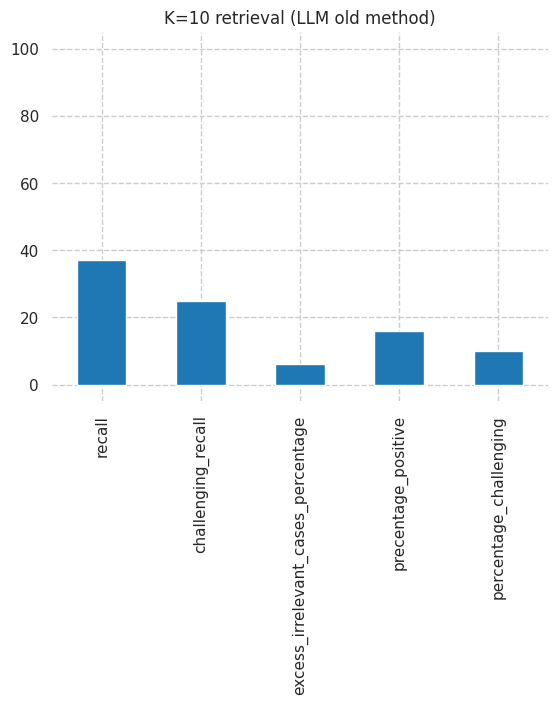

In [36]:
matched_ids_list =  [extract_matches_from_results(results) for results in results_list_open_ai]

performance_data_semantic_search = extract_performance_data(matched_ids_list, curated_examples)
plot_df = performance_data_semantic_search

sns.set_context("notebook", font_scale=1.0)  # Adjust the 'font_scale' value as needed

summary = plot_df[plot_df.k_retrieve == 10].mean()[plot_columns]
ax = summary.plot.bar()
ax.set_title("K=10 retrieval (LLM old method)")
ax.set_ylim([-5, 105])
summary

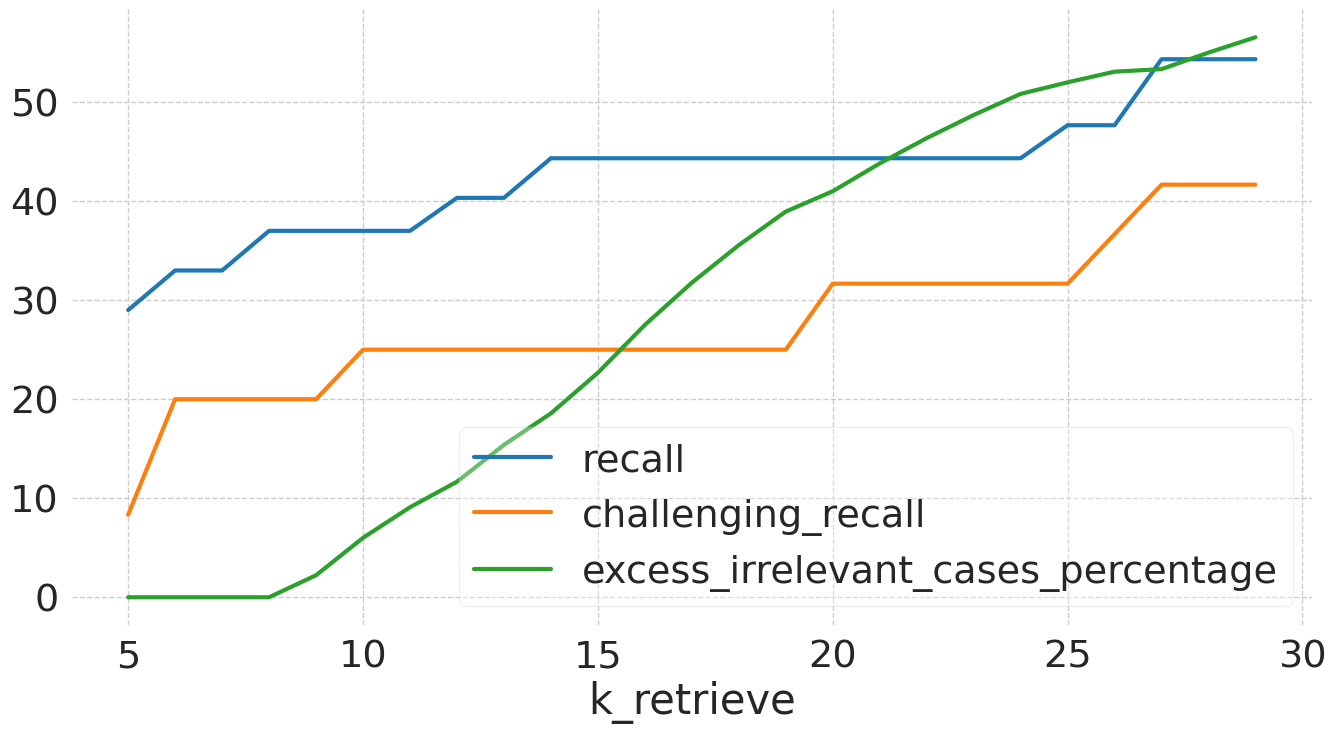

In [37]:

# Adjusting the styling context with a font scale
sns.set_context("notebook", font_scale=2.5)  # Adjust the 'font_scale' value as needed

# Further customization (if necessary)
sns.set_style("whitegrid", {
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.8,
    'axes.edgecolor': 'none'
})

# Sample 
plot_df = performance_data_semantic_search

ax = plot_df.groupby(["k_retrieve"])[plot_columns[:-2]].mean().plot(figsize=(16, 8), linewidth=3)
ax.legend(framealpha=0.3)


# Semantic search

recall                                50.333333
challenging_recall                    30.000000
excess_irrelevant_cases_percentage     8.000000
precentage_positive                   24.000000
percentage_challenging                12.000000
dtype: float64

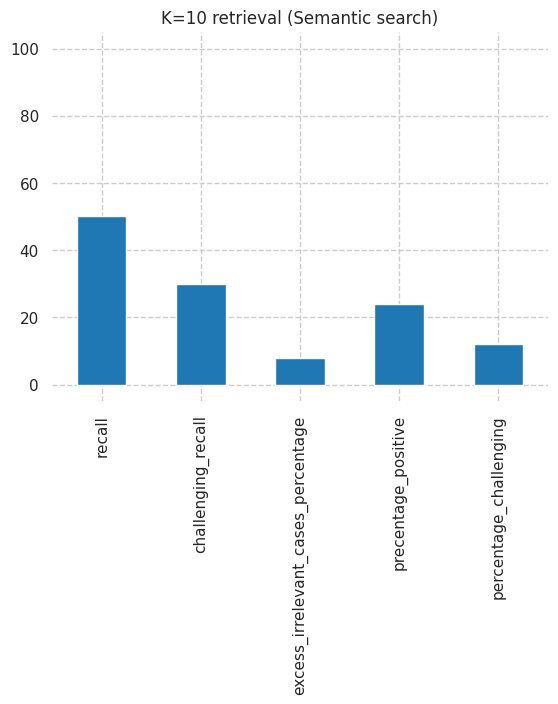

In [34]:
matched_ids_list =  [extract_matches_from_results(results) for results in results_list_semantic_search]
performance_data_semantic_search = extract_performance_data(matched_ids_list, curated_examples)

plot_df = performance_data_semantic_search

sns.set_context("notebook", font_scale=1.0)  # Adjust the 'font_scale' value as needed

summary = plot_df[plot_df.k_retrieve == 10].mean()[plot_columns]
ax = summary.plot.bar()
ax.set_title("K=10 retrieval (Semantic search)")
ax.set_ylim([-5, 105])
summary

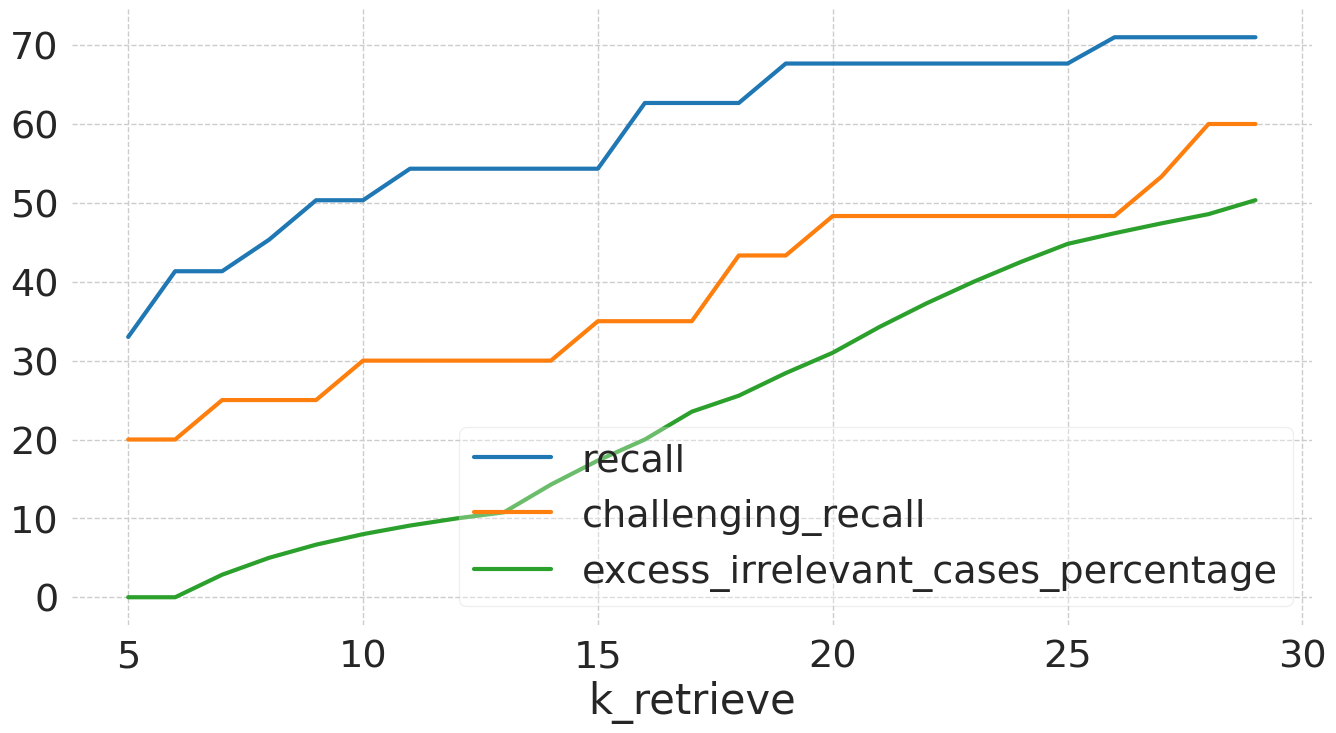

In [32]:

# Adjusting the styling context with a font scale
sns.set_context("notebook", font_scale=2.5)  # Adjust the 'font_scale' value as needed

# Further customization (if necessary)
sns.set_style("whitegrid", {
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.8,
    'axes.edgecolor': 'none'
})

# Sample 

ax = plot_df.groupby(["k_retrieve"])[plot_columns[:-2]].mean().plot(figsize=(16, 8), linewidth=3)
ax.legend(framealpha=0.3)


## Semantic search plus LLM re-ranking

recall                                67.666667
challenging_recall                    21.666667
excess_irrelevant_cases_percentage     6.000000
precentage_positive                   32.000000
percentage_challenging                 8.000000
dtype: float64

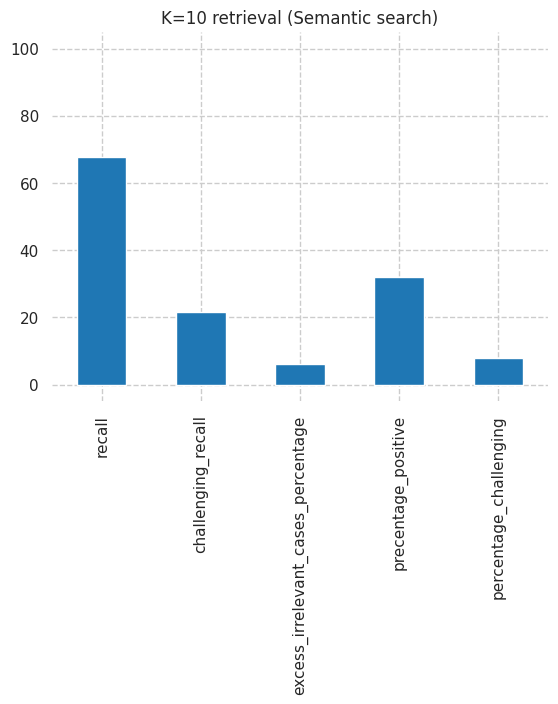

In [40]:
from grountology.ontology_grounding import rerank  

reranked_results_list = [rerank(results, text) for (results, text) in zip(results_list_semantic_search, text_list)]


matched_ids_list =  [extract_matches_from_results(results) for results in reranked_results_list]
performance_data_reranking_with_llm = extract_performance_data(matched_ids_list, curated_examples)
plot_df = performance_data_reranking_with_llm


sns.set_context("notebook", font_scale=1.0)  # Adjust the 'font_scale' value as needed

summary = plot_df[plot_df.k_retrieve == 10].mean()[plot_columns]
ax = summary.plot.bar()
ax.set_title("K=10 retrieval (Semantic search)")
ax.set_ylim([-5, 105])
summary


In [ ]:

# Adjusting the styling context with a font scale
sns.set_context("notebook", font_scale=2.5)  # Adjust the 'font_scale' value as needed

# Further customization (if necessary)
sns.set_style("whitegrid", {
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.8,
    'axes.edgecolor': 'none'
})

# Sample 

ax = plot_df.groupby(["k_retrieve"])[plot_columns[:-2]].mean().plot(figsize=(16, 8), linewidth=3)
ax.legend(framealpha=0.3)
